In [1]:
%matplotlib inline

In [2]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

# 2M0030-1450

In [49]:
# read in data
M0030_1450 = readsav('2M0030-1450_calibch1_bin5_ap_opt.sav')
time_M0030_1450 = np.array(M0030_1450['bint'][:,0],dtype='float64')
flux_M0030_1450 = np.array(M0030_1450['binflux'][:,0],dtype='float64')
peakp_M0030_1450 = np.array(M0030_1450['peakp'],dtype='float64')
name_M0030_1450=M0030_1450['targ_name'].decode('utf-8')
# calculate error
fluxerr_M0030_1450 = np.zeros_like(flux_M0030_1450) + np.std(flux_M0030_1450 - np.roll(flux_M0030_1450, 1))/np.sqrt(2)

In [50]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=5, reflected=False)
map.obl = 0
map.inc = 90

In [51]:
## set the data vector (the flux and the covariance matrix)
map.set_data(flux_M0030_1450, C=fluxerr_M0030_1450)

In [52]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [53]:
### More map variables

nrot=max(time_M0030_1450)/4.22 # Calculate the number of rotations
npts = len(time_M0030_1450) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(time_M0030_1450, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [54]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 162 ms, sys: 9.56 ms, total: 171 ms
Wall time: 169 ms


In [55]:
map.show(colorbar=True, projection="moll",file="M0030-1450\M00300-1450_ydeg5.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


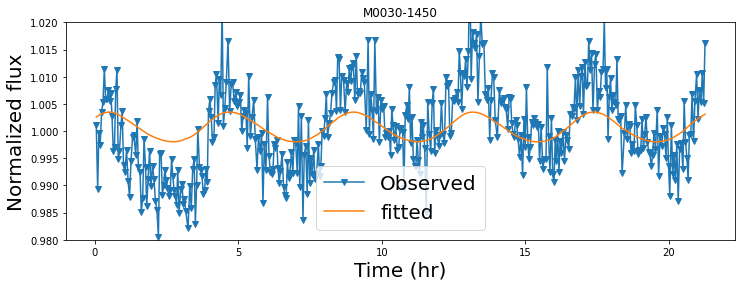

In [57]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("M0030-1450")
plt.plot(time_M0030_1450, flux_M0030_1450, marker="v",label="Observed")
plt.ylim(0.98,1.02)
plt.plot(time_M0030_1450, map.flux(**kwargs),label="fitted")
plt.legend(prop={'size': 20})
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("M0030_1450_LightCurve.jpg")

# 2M0642+4101

In [58]:
# read in data
M0642_4101 = readsav('2M0642+4101_calibch1_bin5_ap_opt.sav')
time_M0642_4101 = np.array(M0642_4101['bint'][:,0],dtype='float64')
flux_M0642_4101 = np.array(M0642_4101['binflux'][:,0],dtype='float64')
peakp_M0642_4101 = np.array(M0642_4101['peakp'],dtype='float64')
name_M0642_4101=M0642_4101['targ_name'].decode('utf-8')
# calculate error
fluxerr_M0642_4101 = np.zeros_like(flux_M0642_4101) + np.std(flux_M0642_4101 - np.roll(flux_M0642_4101, 1))/np.sqrt(2)

In [59]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=5, reflected=False)
map.obl = 0
map.inc = 90

In [60]:
## set the data vector (the flux and the covariance matrix)
map.set_data(flux_M0642_4101, C=fluxerr_M0642_4101)

In [61]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [62]:
### More map variables

nrot=max(time_M0642_4101)/10.11 # Calculate the number of rotations
npts = len(time_M0642_4101) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(time_M0642_4101, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [63]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 168 ms, sys: 32.9 ms, total: 201 ms
Wall time: 293 ms


In [64]:
map.show(colorbar=True, projection="moll",file="M0642+4101/M0642_4101_ydeg5.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


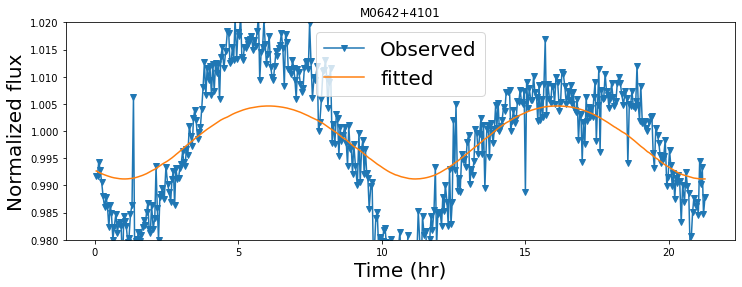

In [65]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("M0642+4101")
plt.plot(time_M0642_4101, flux_M0642_4101, marker="v",label="Observed")
plt.ylim(0.98,1.02)
plt.plot(time_M0642_4101, map.flux(**kwargs),label="fitted")
plt.legend(prop={'size': 20})
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("M0642_4101_LightCurve.jpg")